<center><h1>1-ab: Introduction to Neural Networks</h1></center>

<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>

# Warning :
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.


In [1]:
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/2-ab.zip
!unzip -j 2-ab.zip
!wget https://github.com/rdfia/rdfia.github.io/raw/master/code/2-ab/utils-data.py

--2023-11-07 21:30:03--  https://github.com/rdfia/rdfia.github.io/raw/master/data/2-ab.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/2-ab.zip [following]
--2023-11-07 21:30:03--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/2-ab.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13423991 (13M) [application/zip]
Saving to: ‘2-ab.zip’

2-ab.zip            100%[===================>]  12.80M  40.6MB/s    in 0.3s    

2023-11-07 21:30:04 (40.6 MB/s) - ‘2-ab.zip’ saved [13423991/13423991]

Archive:  2-ab.zip
  inflating: ._2-ab         

In [2]:
import math
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%run 'utils-data.py'

# Part 1 : Forward and backward passes "by hands"

In [62]:
def init_params(nx, nh, ny):
    """
    Initialize neural network parameters.

    Args:
    nx (int): Size of the input.
    nh (int): Size of the output of the first hidden layer.
    ny (int): Size of the output of the final layer.

    Returns:
    params (dict): Dictionary containing initialized parameters.
    """
    params = {}

    # Initialize weights with a normal distribution (mean=0, std=0.3)
    params["Wh"] = torch.randn(nh, nx) * 0.3
    params["Wy"] = torch.randn(ny, nh) * 0.3

    # Initialize biases as zeros
    params["bh"] = torch.randn(nh)
    params["by"] = torch.randn(ny)

    return params


In [63]:
def forward(params, X):
    """
    Perform the forward pass of a neural network.

    Args:
    params (dict): Dictionary containing neural network parameters.
    X (torch.Tensor): Input data of shape (n_batch, dimension).

    Returns:
    yhat (torch.Tensor): Predicted output probabilities of shape (n_batch, num_classes).
    outputs (dict): Dictionary containing intermediate results of the forward pass.
    """
    bsize = X.size(0)
    nh = params["Wh"].size(0)
    ny = params["Wy"].size(0)
    outputs = {}

    # Forward pass

    outputs["X"] = X
    outputs["htilde"] = torch.mm(X, params["Wh"].t()) + params["bh"].repeat(bsize, 1)
    outputs["h"] = torch.tanh(outputs["htilde"])
    outputs["ytilde"] = torch.mm(outputs["h"], params["Wy"].t()) + params["by"].repeat(bsize, 1)
    outputs["yhat"] = torch.softmax(outputs["ytilde"], dim=1)

    return outputs["yhat"], outputs


In [64]:
def loss_accuracy(Yhat, Y):
    """
    Calculate the loss and accuracy of a neural network's predictions.

    Args:
    Yhat (torch.Tensor): Predicted probabilities of shape (n_batch, num_classes).
    Y (torch.Tensor): True labels of shape (n_batch, num_classes).

    Returns:
    L (torch.Tensor): Loss value.
    acc (torch.Tensor): Accuracy as a percentage.
    """
    # Compute the loss
    L = -torch.mean(torch.sum(Y * torch.log(Yhat)))

    # Find the predicted class for each example
    _, indsYhat = torch.max(Yhat, 1)
    _, indsY = torch.max(Y, 1)

    # Compute the accuracy (rate of correct predictions)
    acc = 100 * torch.sum(indsYhat == indsY) / indsY.size(0)

    return L, acc


In [65]:
def backward(params, outputs, Y):
    """
    Perform the backward pass to compute gradients.

    Args:
    params (dict): Dictionary containing neural network parameters.
    outputs (dict): Dictionary containing intermediate results of the forward pass.
    Y (torch.Tensor): True labels of shape (n_batch, num_classes).

    Returns:
    grads (dict): Dictionary containing computed gradients.
    """
    bsize = Y.shape[0]
    grads = {}

    # Backward pass
    grads["yhat"] = outputs["yhat"] - Y
    grads["Wy"] = torch.mm(grads["yhat"].t(), outputs["h"])
    grads["by"] = torch.sum(grads["yhat"], dim=0).t()
    grads["htilde"] = torch.mm(grads["yhat"], params["Wy"]) * (1 - outputs["h"] ** 2)
    grads["Wh"] = torch.mm(grads["htilde"].t(), outputs["X"])
    grads["bh"] = torch.sum(grads["htilde"]).t()

    return grads

In [66]:
def sgd(params, grads, eta):
    """
    Perform a stochastic gradient descent (SGD) update on the parameters.

    Args:
    params (dict): Dictionary containing neural network parameters.
    grads (dict): Dictionary containing gradients.
    eta (float): Learning rate for the update.

    Returns:
    params (dict): Updated parameters after the SGD update.
    """
    params["Wh"] -= eta * grads["Wh"]
    params["Wy"] -= eta * grads["Wy"]
    params["bh"] -= eta * grads["bh"]
    params["by"] -= eta * grads["by"]

    return params


## Global learning procedure "by hands"

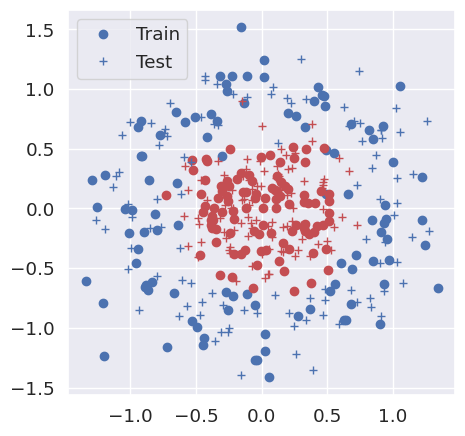

Iter 149: Acc train 93.0% (26.48), acc test 92.0% (43.92)


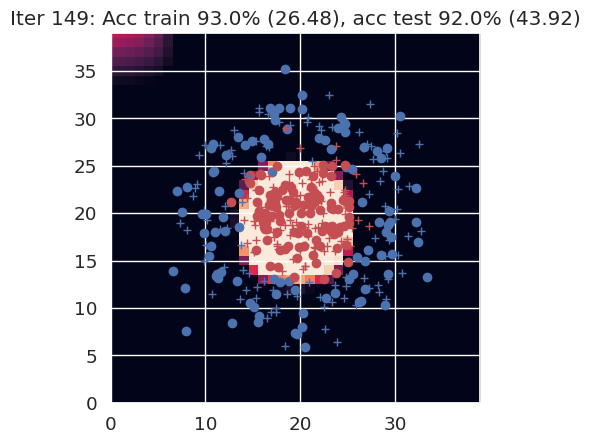

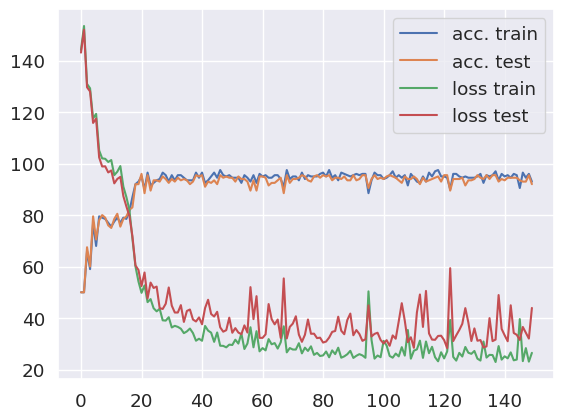

In [70]:
# Initialization
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03

# Initialize parameters
params = init_params(nx, nh, ny)
curves = [[], [], [], []]

# Training loop
for iteration in range(150):

    # Shuffle data
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    # Batch training
    for j in range(N // Nbatch):
        indsBatch = range(j * Nbatch, (j + 1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        # Forward pass, compute loss and accuracy, and perform backward pass
        yhat, outputs = forward(params, X)
        L, acc = loss_accuracy(yhat, Y)
        grads = backward(params, outputs, Y)
        params = sgd(params, grads, eta)

    # Evaluate and store results
    Yhat_train, _ = forward(params, data.Xtrain)
    Yhat_test, _ = forward(params, data.Xtest)
    Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)
    Ygrid, _ = forward(params, data.Xgrid)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain)
    curves[3].append(Ltest)

# Print final results and plot curves
title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain, acctest, Ltest)
print(title)
data.plot_data_with_grid(Ygrid, title)

# Save the figure as "manual_acc_loss.pdf"
fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.legend()
plt.savefig("manual_acc_loss.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [68]:
# Define the backward function
def custom_backward(params, outputs, Y):
    bsize = Y.shape[0]
    grads = {}

    # Compute gradients during the backward pass
    grads["yhat"] = outputs["yhat"] - Y
    grads["Wy"] = torch.mm(grads["yhat"].t(), outputs["h"]) / bsize
    grads["by"] = torch.sum(grads["yhat"], dim=0).t() / bsize
    grads["htilde"] = torch.mm(grads["yhat"], params["Wy"]) * (1 - outputs["h"] ** 2)
    grads["Wh"] = torch.mm(grads["htilde"].t(), outputs["X"]) / bsize
    grads["bh"] = torch.sum(grads["htilde"]).t() / bsize

    return grads

  0%|          | 0/500 [00:00<?, ?it/s]

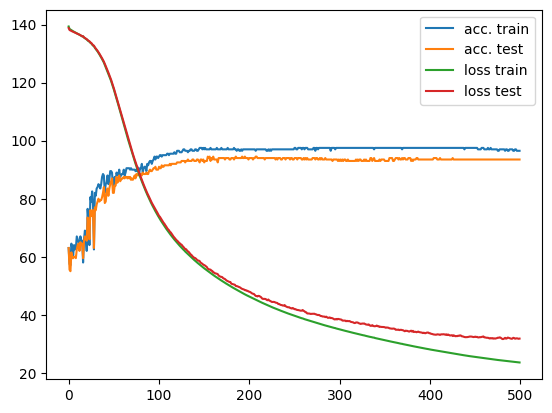

In [33]:
from tqdm.autonotebook import tqdm, trange



# Initialize data, parameters, and hyperparameters
data = CirclesData()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03

params = init_params(nx, nh, ny)

curves = [[], [], [], []]

pbar = trange(500)

# Training loop
for iteration in pbar:
    # Shuffle the data
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    # Mini-batch training
    for j in range(N // Nbatch):
        indsBatch = range(j * Nbatch, (j + 1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        # Forward pass
        Yhat, outputs = forward(params, X)

        # Calculate loss and accuracy
        L, acc = loss_accuracy(Yhat, Y)

        # Backward pass using the custom backward function
        grads = custom_backward(params, outputs, Y)

        # Update parameters using SGD
        params = sgd(params, grads, eta)

    # Evaluate on train and test sets
    Yhat_train, _ = forward(params, data.Xtrain)
    Yhat_test, _ = forward(params, data.Xtest)
    Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)
    Ygrid, _ = forward(params, data.Xgrid)

    title = "Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})".format(
        iteration + 1, acctrain, Ltrain, acctest, Ltest
    )
    pbar.set_description(title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain)
    curves[3].append(Ltest)

# Plot and save the results
fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.legend()
plt.savefig("manual_acc_loss_bis.pdf", format="pdf", bbox_inches="tight")
plt.show()



# Influence of learning rate

LR: 0.001:   0%|          | 0/500 [00:00<?, ?it/s]

LR: 0.005:   0%|          | 0/500 [00:00<?, ?it/s]

LR: 0.01:   0%|          | 0/500 [00:00<?, ?it/s]

LR: 0.05:   0%|          | 0/500 [00:00<?, ?it/s]

LR: 0.1:   0%|          | 0/500 [00:00<?, ?it/s]

LR: 0.5:   0%|          | 0/500 [00:00<?, ?it/s]

LR: 1.0:   0%|          | 0/500 [00:00<?, ?it/s]

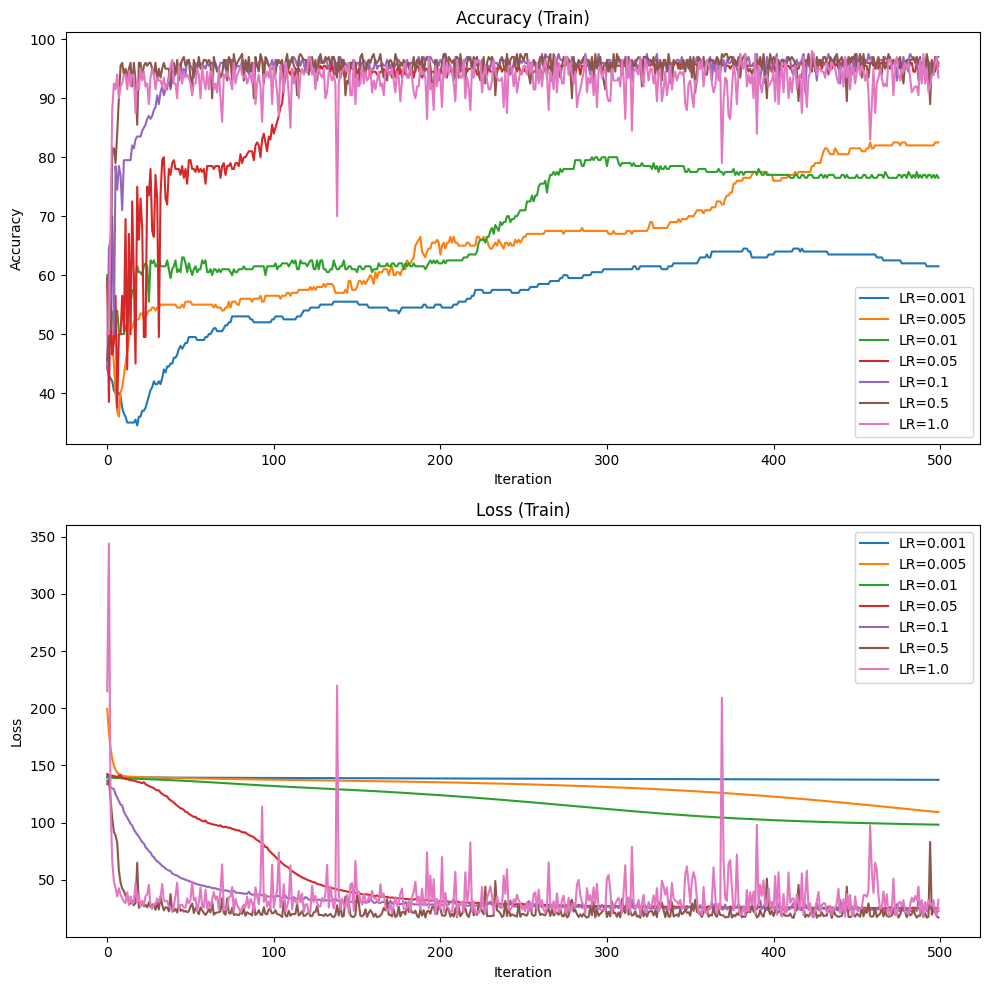

In [34]:
from tqdm.autonotebook import tqdm, trange

def train_with_learning_rates(learning_rates, num_iterations=500):
    data = CirclesData()
    N = data.Xtrain.shape[0]
    Nbatch = 10
    nx = data.Xtrain.shape[1]
    nh = 10
    ny = data.Ytrain.shape[1]

    curves = {lr: [[], [], [], []] for lr in learning_rates}

    for lr in learning_rates:
        params = init_params(nx, nh, ny)
        pbar = trange(num_iterations, desc=f"LR: {lr}")

        for iteration in pbar:
            perm = np.random.permutation(N)
            Xtrain = data.Xtrain[perm, :]
            Ytrain = data.Ytrain[perm, :]

            for j in range(N // Nbatch):
                indsBatch = range(j * Nbatch, (j + 1) * Nbatch)
                X = Xtrain[indsBatch, :]
                Y = Ytrain[indsBatch, :]

                # Forward pass
                Yhat, outputs = forward(params, X)

                # Calculate loss and accuracy
                L, acc = loss_accuracy(Yhat, Y)

                # Backward pass
                grads = custom_backward(params, outputs, Y)

                # Update parameters using SGD
                params = sgd(params, grads, lr)

            Yhat_train, _ = forward(params, data.Xtrain)
            Yhat_test, _ = forward(params, data.Xtest)
            Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
            Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)

            curves[lr][0].append(acctrain)
            curves[lr][1].append(acctest)
            curves[lr][2].append(Ltrain.detach().numpy())
            curves[lr][3].append(Ltest.detach().numpy())

            title = f"LR: {lr}, Iter {iteration + 1}: Acc train {acctrain:.1f}% ({Ltrain:.2f}), acc test {acctest:.1f}% ({Ltest:.2f})"
            pbar.set_description(title)

    return curves

learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
curves = train_with_learning_rates(learning_rates)

import matplotlib.pyplot as plt

# Plot the results for each learning rate
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
for lr, curve in curves.items():
    axes[0].plot(curve[0], label=f"LR={lr}")
    axes[1].plot(curve[2], label=f"LR={lr}")

axes[0].set_title("Accuracy (Train)")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

axes[1].set_title("Loss (Train)")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Loss")
axes[1].legend()

plt.tight_layout()
plt.savefig("manual_lr.pdf", format="pdf", bbox_inches="tight")
plt.show()


Influence of batch size

Batch Size: 8:   0%|          | 0/500 [00:00<?, ?it/s]

Batch Size: 16:   0%|          | 0/500 [00:00<?, ?it/s]

Batch Size: 32:   0%|          | 0/500 [00:00<?, ?it/s]

Batch Size: 64:   0%|          | 0/500 [00:00<?, ?it/s]

Batch Size: 128:   0%|          | 0/500 [00:00<?, ?it/s]

Batch Size: 256:   0%|          | 0/500 [00:00<?, ?it/s]

Batch Size: 512:   0%|          | 0/500 [00:00<?, ?it/s]

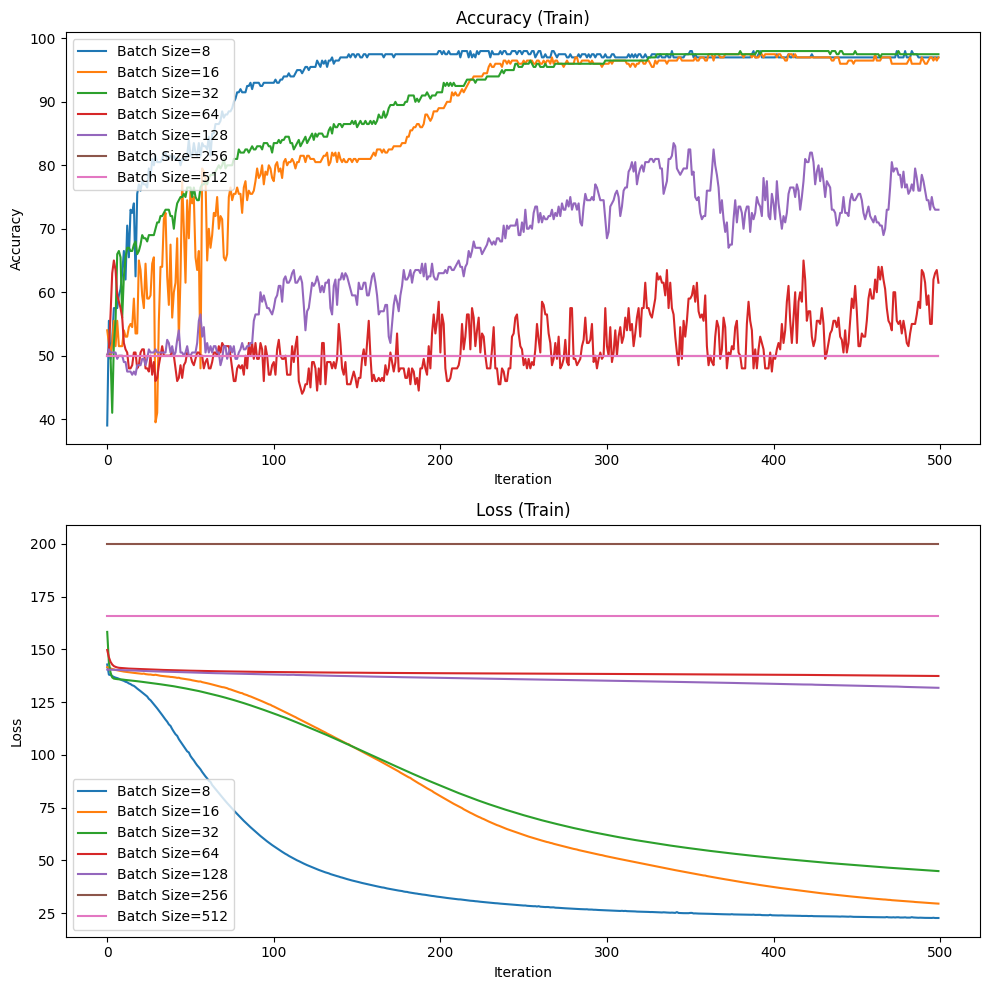

In [35]:
from tqdm.autonotebook import tqdm, trange

def train_with_batch_sizes(batch_sizes, num_iterations=500):
    data = CirclesData()
    N = data.Xtrain.shape[0]
    nx = data.Xtrain.shape[1]
    nh = 10
    ny = data.Ytrain.shape[1]

    curves = {Nbatch: [[], [], [], []] for Nbatch in batch_sizes}

    for Nbatch in batch_sizes:
        params = init_params(nx, nh, ny)
        pbar = trange(num_iterations, desc=f"Batch Size: {Nbatch}")

        for iteration in pbar:
            perm = np.random.permutation(N)
            Xtrain = data.Xtrain[perm, :]
            Ytrain = data.Ytrain[perm, :]

            for j in range(N // Nbatch):
                indsBatch = range(j * Nbatch, (j + 1) * Nbatch)
                X = Xtrain[indsBatch, :]
                Y = Ytrain[indsBatch, :]

                # Forward pass
                Yhat, outputs = forward(params, X)

                # Calculate loss and accuracy
                L, acc = loss_accuracy(Yhat, Y)

                # Backward pass
                grads = custom_backward(params, outputs, Y)

                # Update parameters using SGD
                params = sgd(params, grads, eta)

            Yhat_train, _ = forward(params, data.Xtrain)
            Yhat_test, _ = forward(params, data.Xtest)
            Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
            Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)

            curves[Nbatch][0].append(acctrain)
            curves[Nbatch][1].append(acctest)
            curves[Nbatch][2].append(Ltrain.detach().numpy())
            curves[Nbatch][3].append(Ltest.detach().numpy())

            title = f"Batch Size: {Nbatch}, Iter {iteration + 1}: Acc train {acctrain:.1f}% ({Ltrain:.2f}), acc test {acctest:.1f}% ({Ltest:.2f})"
            pbar.set_description(title)

    return curves

batch_sizes = [8, 16, 32, 64, 128, 256, 512]
curves = train_with_batch_sizes(batch_sizes)

import matplotlib.pyplot as plt

# Plot the results for each batch size
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
for Nbatch, curve in curves.items():
    axes[0].plot(curve[0], label=f"Batch Size={Nbatch}")
    axes[1].plot(curve[2], label=f"Batch Size={Nbatch}")

axes[0].set_title("Accuracy (Train)")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

axes[1].set_title("Loss (Train)")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Loss")
axes[1].legend()

plt.tight_layout()
plt.savefig("manual_batchsize.pdf", format="pdf", bbox_inches="tight")
plt.show()


# Part 2 : Simplification of the backward pass with `torch.autograd`



In [36]:
def init_params(nx, nh, ny):
    """
    Initialize parameters for a neural network.

    Args:
    nx (int): Input size.
    nh (int): Size of the hidden layer.
    ny (int): Output size.

    Returns:
    dict: Dictionary containing initialized parameters.
    """
    params = {
        "Wh": torch.randn(nh, nx, requires_grad=True),
        "Wy": torch.randn(ny, nh, requires_grad=True),
        "bh": torch.zeros(nh, requires_grad=True),
        "by": torch.zeros(ny, requires_grad=True)
    }

    return params


The function `forward` remains unchanged from previous part.

The function `backward` is no longer used because of "autograd".

In [37]:
def sgd(params, eta):
    """
    Update the network weights using Stochastic Gradient Descent (SGD).

    Args:
    params (dict): Dictionary containing network parameters with gradients.
    eta (float): Learning rate.

    Returns:
    dict: Updated network parameters.
    """
    with torch.no_grad():
        for param_name, param_value in params.items():
            if param_value.grad is not None:
                param_value -= eta * param_value.grad
                param_value.grad.zero_()

    return params


## Global learning procedure with autograd

Training Progress:   0%|          | 0/150 [00:00<?, ?it/s]

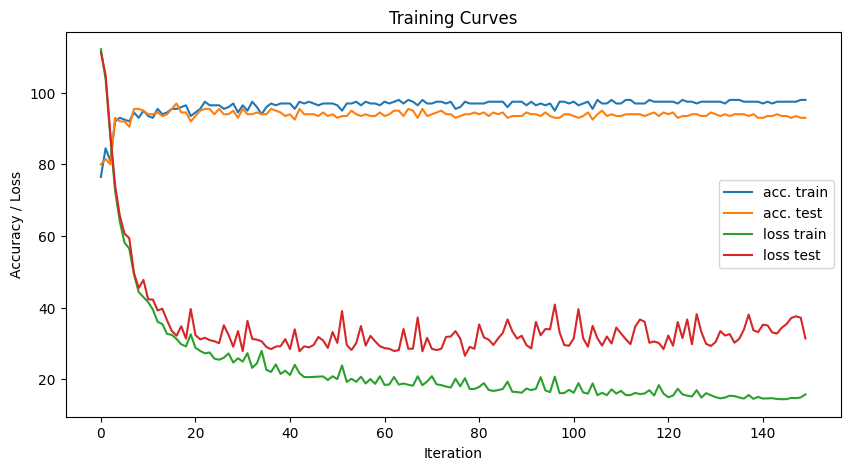

In [38]:
import torch
import numpy as np
from tqdm.autonotebook import trange
import matplotlib.pyplot as plt

# Define functions
def shuffle_data(data):
    N = data.Xtrain.shape[0]
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]
    return Xtrain, Ytrain

def train_one_iteration(params, data, Nbatch, eta):
    Xtrain, Ytrain = shuffle_data(data)

    for j in range(N // Nbatch):
        indsBatch = range(j * Nbatch, (j + 1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        # Forward pass
        Yhat, outputs = forward(params, X)

        # Calculate loss and accuracy
        L, acc = loss_accuracy(Yhat, Y)
        L.backward()

        # Update parameters using SGD
        params = sgd(params, eta)

    return params, L, acc

def plot_training_curves(curves):
    fig, ax = plt.subplots(figsize=(10, 5))
    iterations = range(len(curves[0]))

    ax.plot(iterations, curves[0], label="acc. train")
    ax.plot(iterations, curves[1], label="acc. test")
    ax.plot(iterations, curves[2], label="loss train")
    ax.plot(iterations, curves[3], label="loss test")

    ax.set_title("Training Curves")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Accuracy / Loss")
    ax.legend()

    plt.savefig("autograd_acc_loss.pdf", format="pdf", bbox_inches="tight")
    plt.show()

# Initialize data, parameters, and hyperparameters
data = CirclesData()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03

params = init_params(nx, nh, ny)
curves = [[], [], [], []]

# Training loop
num_iterations = 150
pbar = trange(num_iterations, desc="Training Progress")

for iteration in pbar:
    params, L, acc = train_one_iteration(params, data, Nbatch, eta)
    Yhat_train, _ = forward(params, data.Xtrain)
    Yhat_test, _ = forward(params, data.Xtest)
    Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)

    title = f"Iter {iteration + 1}: Acc train {acctrain:.1f}% ({Ltrain:.2f}), acc test {acctest:.1f}% ({Ltest:.2f})"
    pbar.set_description(title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain.detach().numpy())
    curves[3].append(Ltest.detach().numpy())

# Plot training curves
plot_training_curves(curves)


Learning rate influence

LR: 0.001:   0%|          | 0/150 [00:00<?, ?it/s]

LR: 0.005:   0%|          | 0/150 [00:00<?, ?it/s]

LR: 0.01:   0%|          | 0/150 [00:00<?, ?it/s]

LR: 0.05:   0%|          | 0/150 [00:00<?, ?it/s]

LR: 0.1:   0%|          | 0/150 [00:00<?, ?it/s]

LR: 0.5:   0%|          | 0/150 [00:00<?, ?it/s]

LR: 1.0:   0%|          | 0/150 [00:00<?, ?it/s]

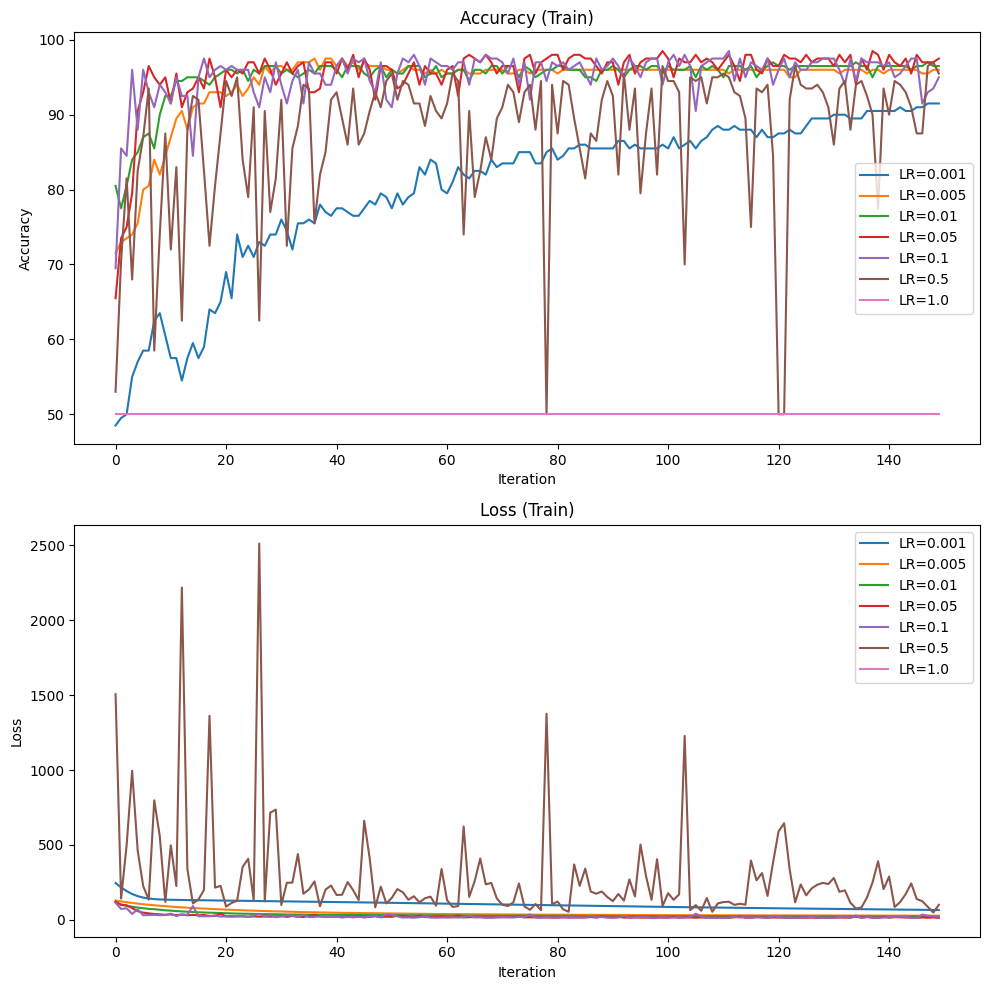

In [39]:
import torch
import numpy as np
from tqdm.autonotebook import trange
import matplotlib.pyplot as plt

def train_with_lr(data, num_iterations, learning_rate):
    N = data.Xtrain.shape[0]
    Nbatch = 10
    nx = data.Xtrain.shape[1]
    nh = 10
    ny = data.Ytrain.shape[1]

    params = init_params(nx, nh, ny)
    curves = [[], [], [], []]

    pbar = trange(num_iterations, desc=f"LR: {learning_rate}")

    for iteration in pbar:
        perm = np.random.permutation(N)
        Xtrain = data.Xtrain[perm, :]
        Ytrain = data.Ytrain[perm, :]

        for j in range(N // Nbatch):
            indsBatch = range(j * Nbatch, (j + 1) * Nbatch)
            X = Xtrain[indsBatch, :]
            Y = Ytrain[indsBatch, :]

            # Forward pass
            Yhat, outputs = forward(params, X)

            # Calculate loss and accuracy
            L, acc = loss_accuracy(Yhat, Y)
            L.backward()

            # Update parameters using SGD
            params = sgd(params, learning_rate)

        Yhat_train, _ = forward(params, data.Xtrain)
        Yhat_test, _ = forward(params, data.Xtest)
        Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
        Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)

        curves[0].append(acctrain)
        curves[1].append(acctest)
        curves[2].append(Ltrain.detach().numpy())
        curves[3].append(Ltest.detach().numpy())

        title = f"LR: {learning_rate}, Iter {iteration + 1}: Acc train {acctrain:.1f}% ({Ltrain:.2f}), acc test {acctest:.1f}% ({Ltest:.2f})"
        pbar.set_description(title)

    return curves

# Initialize data and hyperparameters
data = CirclesData()
num_iterations = 150
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
curves_dict = {}

# Train with different learning rates
for lr in learning_rates:
    curves = train_with_lr(data, num_iterations, lr)
    curves_dict[lr] = curves

# Plot the results for each learning rate
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
for lr, curve in curves_dict.items():
    axes[0].plot(curve[0], label=f"LR={lr}")
    axes[1].plot(curve[2], label=f"LR={lr}")

axes[0].set_title("Accuracy (Train)")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

axes[1].set_title("Loss (Train)")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Loss")
axes[1].legend()

plt.tight_layout()
plt.savefig("autograd_lr.pdf", format="pdf", bbox_inches="tight")
plt.show()


# Batch size influence

Batch Size: 8:   0%|          | 0/150 [00:00<?, ?it/s]

Batch Size: 16:   0%|          | 0/150 [00:00<?, ?it/s]

Batch Size: 32:   0%|          | 0/150 [00:00<?, ?it/s]

Batch Size: 64:   0%|          | 0/150 [00:00<?, ?it/s]

Batch Size: 128:   0%|          | 0/150 [00:00<?, ?it/s]

Batch Size: 256:   0%|          | 0/150 [00:00<?, ?it/s]

Batch Size: 512:   0%|          | 0/150 [00:00<?, ?it/s]

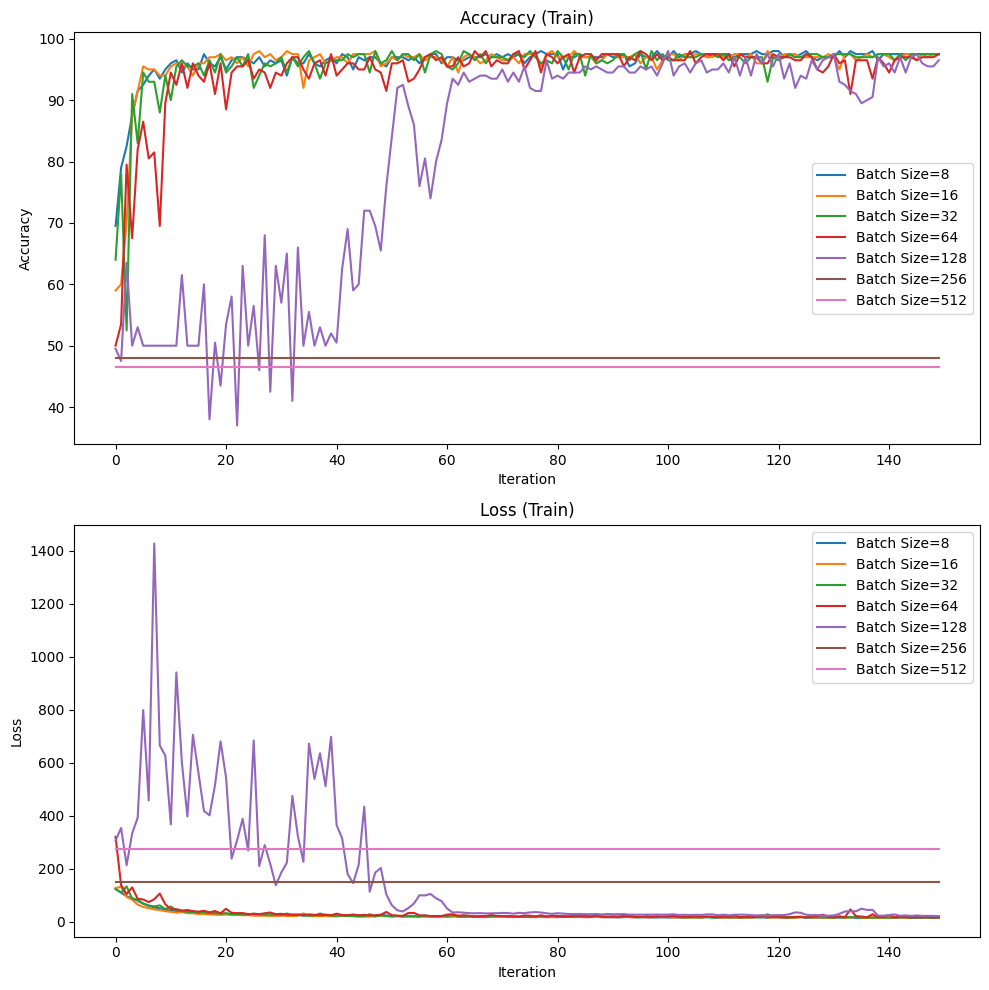

In [40]:
import torch
import numpy as np
from tqdm.autonotebook import trange
import matplotlib.pyplot as plt

def train_with_batch_size(data, num_iterations, batch_size):
    N = data.Xtrain.shape[0]
    nx = data.Xtrain.shape[1]
    nh = 10
    ny = data.Ytrain.shape[1]
    eta = 0.03

    params = init_params(nx, nh, ny)
    curves = [[], [], [], []]

    pbar = trange(num_iterations, desc=f"Batch Size: {batch_size}")

    for iteration in pbar:
        perm = np.random.permutation(N)
        Xtrain = data.Xtrain[perm, :]
        Ytrain = data.Ytrain[perm, :]

        for j in range(N // batch_size):
            indsBatch = range(j * batch_size, (j + 1) * batch_size)
            X = Xtrain[indsBatch, :]
            Y = Ytrain[indsBatch, :]

            # Forward pass
            Yhat, outputs = forward(params, X)

            # Calculate loss and accuracy
            L, acc = loss_accuracy(Yhat, Y)
            L.backward()

            # Update parameters using SGD
            params = sgd(params, eta)

        Yhat_train, _ = forward(params, data.Xtrain)
        Yhat_test, _ = forward(params, data.Xtest)
        Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
        Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)

        curves[0].append(acctrain)
        curves[1].append(acctest)
        curves[2].append(Ltrain.detach().numpy())
        curves[3].append(Ltest.detach().numpy())

        title = f"Batch Size: {batch_size}, Iter {iteration + 1}: Acc train {acctrain:.1f}% ({Ltrain:.2f}), acc test {acctest:.1f}% ({Ltest:.2f})"
        pbar.set_description(title)

    return curves

# Initialize data and hyperparameters
data = CirclesData()
num_iterations = 150
batch_sizes = [8, 16, 32, 64, 128, 256, 512]
curves_dict = {}

# Train with different batch sizes
for batch_size in batch_sizes:
    curves = train_with_batch_size(data, num_iterations, batch_size)
    curves_dict[batch_size] = curves

# Plot the results for each batch size
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
for batch_size, curve in curves_dict.items():
    axes[0].plot(curve[0], label=f"Batch Size={batch_size}")
    axes[1].plot(curve[2], label=f"Batch Size={batch_size}")

axes[0].set_title("Accuracy (Train)")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

axes[1].set_title("Loss (Train)")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Loss")
axes[1].legend()

plt.tight_layout()
plt.savefig("autograd_batchsize.pdf", format="pdf", bbox_inches="tight")
plt.show()


# Part 3 : Simplification of the forward pass with `torch.nn`

`init_params` and `forward` are replaced by the `init_model` function which defines the network architecture and the loss.

In [41]:
import torch.nn as nn

def init_model(nx, nh, ny):
    """
    Initialize a neural network model and a loss function.

    Parameters:
        nx (int): Number of input features.
        nh (int): Number of hidden units.
        ny (int): Number of output units.

    Returns:
        model (nn.Module): Initialized neural network model.
        loss_fn (nn.Module): Loss function.
    """
    model = nn.Sequential(
        nn.Linear(nx, nh),
        nn.Tanh(),
        nn.Linear(nh, ny)
    )
    loss_fn = nn.CrossEntropyLoss()
    return model, loss_fn


In [42]:
import torch

def loss_accuracy(loss_fn, Yhat, Y):
    """
    Calculate loss and accuracy given predictions and true labels.

    Parameters:
        loss_fn (callable): Loss function to compute the loss.
        Yhat (torch.Tensor): Predictions from the model.
        Y (torch.Tensor): True labels.

    Returns:
        tuple: A tuple containing loss (L) and accuracy (acc).
    """
    L = loss_fn(Yhat, Y)
    acc = 100 * torch.mean((Yhat.argmax(1) == Y.argmax(1)).float())
    return L, acc


In [43]:
import torch

def sgd(model, eta):
    """
    Perform stochastic gradient descent (SGD) to update the model's parameters.

    Parameters:
        model (torch.nn.Module): The neural network model.
        eta (float): Learning rate for parameter updates.

    Returns:
        torch.nn.Module: Updated model with modified parameters.
    """
    with torch.no_grad():
        for param in model.parameters():
            param -= eta * param.grad
            param.grad.zero_()
    return model


## Global learning procedure with autograd and `torch.nn`

In [ ]:
# Initialize data, parameters, and hyperparameters
data = CirclesData()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03

model, loss_fn = init_model(nx, nh, ny)

curves = [[], [], [], []]

# Training loop
num_iterations = 250
pbar = trange(num_iterations, desc="Training Progress")

for iteration in pbar:
    # Shuffle the data
    perm = torch.randperm(N)
    Xtrain = data.Xtrain[perm]
    Ytrain = data.Ytrain[perm]

    # Batches
    for j in range(N // Nbatch):
        indsBatch = range(j * Nbatch, (j + 1) * Nbatch)
        X = Xtrain[indsBatch]
        Y = Ytrain[indsBatch]

        # Forward pass
        Yhat = model(X)

        # Calculate loss and accuracy
        L, acc = loss_accuracy(loss_fn, Yhat, Y)

        # Backward pass and parameter update using SGD
        L.backward()
        model = sgd(model, eta)

    # Evaluate on training and test data
    Yhat_train = model(data.Xtrain)
    Yhat_test = model(data.Xtest)
    Ltrain, acctrain = loss_accuracy(loss_fn, Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(loss_fn, Yhat_test, data.Ytest)

    title = f"Iter {iteration + 1}: Acc train {acctrain:.1f}% ({Ltrain:.2f}), acc test {acctest:.1f}% ({Ltest:.2f})"
    pbar.set_description(title)

    # Plot data with decision boundary
    data.plot_data_with_grid(torch.nn.Softmax(dim=1)(model(data.Xgrid).detach()), title)

    # Store training curves
    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain.detach())
    curves[3].append(Ltest.detach())

# Plot and save training curves
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].plot(curves[0], label="acc. train")
axes[0].plot(curves[1], label="acc. test")
axes[0].set_title("Learning Curves")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Accuracy (%)")
axes[0].legend()

axes[1].plot(curves[2], label="loss train")
axes[1].plot(curves[3], label="loss test")
axes[1].set_title("Loss Curves")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Loss")
axes[1].legend()

plt.tight_layout()
plt.savefig("torchnn_acc_loss.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Influence of Learning Rate

LR: 0.001:   0%|          | 0/250 [00:00<?, ?it/s]

LR: 0.005:   0%|          | 0/250 [00:00<?, ?it/s]

LR: 0.01:   0%|          | 0/250 [00:00<?, ?it/s]

LR: 0.05:   0%|          | 0/250 [00:00<?, ?it/s]

LR: 0.1:   0%|          | 0/250 [00:00<?, ?it/s]

LR: 0.5:   0%|          | 0/250 [00:00<?, ?it/s]

LR: 1.0:   0%|          | 0/250 [00:00<?, ?it/s]

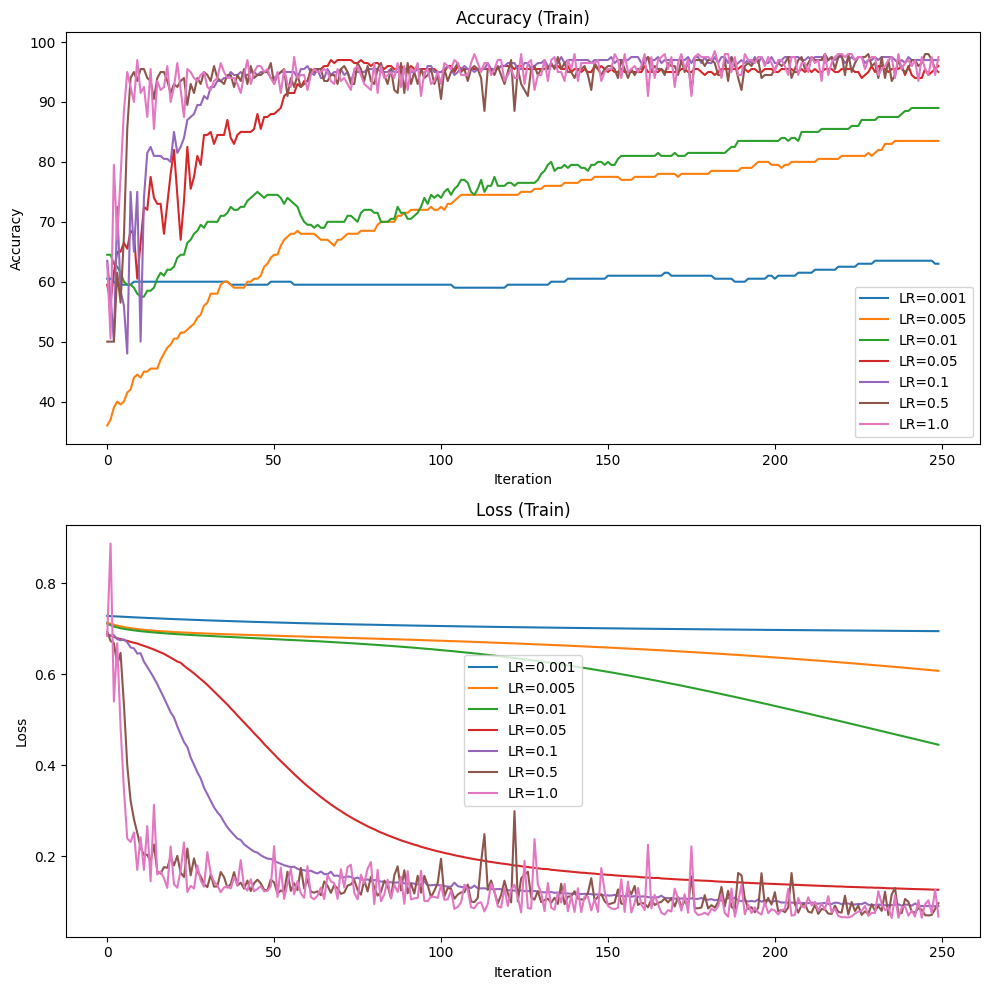

In [45]:
def train_with_lr(data, learning_rate, num_iterations=250):
    N = data.Xtrain.shape[0]
    Nbatch = 10
    nx = data.Xtrain.shape[1]
    nh = 10
    ny = data.Ytrain.shape[1]

    model, loss_fn = init_model(nx, nh, ny)

    curves = [[], [], [], []]

    pbar = trange(num_iterations, desc=f"LR: {learning_rate}")

    for iteration in pbar:
        perm = torch.randperm(N)
        Xtrain = data.Xtrain[perm]
        Ytrain = data.Ytrain[perm]

        for j in range(N // Nbatch):
            indsBatch = range(j * Nbatch, (j + 1) * Nbatch)
            X = Xtrain[indsBatch]
            Y = Ytrain[indsBatch]

            # Forward pass
            Yhat = model(X)

            # Calculate loss and accuracy
            L, acc = loss_accuracy(loss_fn, Yhat, Y)
            L.backward()

            # Update parameters using SGD
            model = sgd(model, eta=learning_rate)

        Yhat_train = model(data.Xtrain)
        Yhat_test = model(data.Xtest)
        Ltrain, acctrain = loss_accuracy(loss_fn, Yhat_train, data.Ytrain)
        Ltest, acctest = loss_accuracy(loss_fn, Yhat_test, data.Ytest)

        curves[0].append(acctrain)
        curves[1].append(acctest)
        curves[2].append(Ltrain.detach().numpy())
        curves[3].append(Ltest.detach().numpy())

        title = f"LR: {learning_rate}, Iter {iteration + 1}: Acc train {acctrain:.1f}% ({Ltrain:.2f}), acc test {acctest:.1f}% ({Ltest:.2f})"
        pbar.set_description(title)

    return curves

# Initialize data and learning rates
data = CirclesData()
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
curves = {}

# Train with different learning rates
for lr in learning_rates:
    curves[lr] = train_with_lr(data, learning_rate=lr)

# Plot the results for each learning rate
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
for lr, curve in curves.items():
    axes[0].plot(curve[0], label=f"LR={lr}")
    axes[1].plot(curve[2], label=f"LR={lr}")

axes[0].set_title("Accuracy (Train)")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

axes[1].set_title("Loss (Train)")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Loss")
axes[1].legend()

plt.tight_layout()
plt.savefig("torchnn_lr.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Influence of batch size

Batch Size: 8:   0%|          | 0/250 [00:00<?, ?it/s]

Batch Size: 16:   0%|          | 0/250 [00:00<?, ?it/s]

Batch Size: 32:   0%|          | 0/250 [00:00<?, ?it/s]

Batch Size: 64:   0%|          | 0/250 [00:00<?, ?it/s]

Batch Size: 128:   0%|          | 0/250 [00:00<?, ?it/s]

Batch Size: 256:   0%|          | 0/250 [00:00<?, ?it/s]

Batch Size: 512:   0%|          | 0/250 [00:00<?, ?it/s]

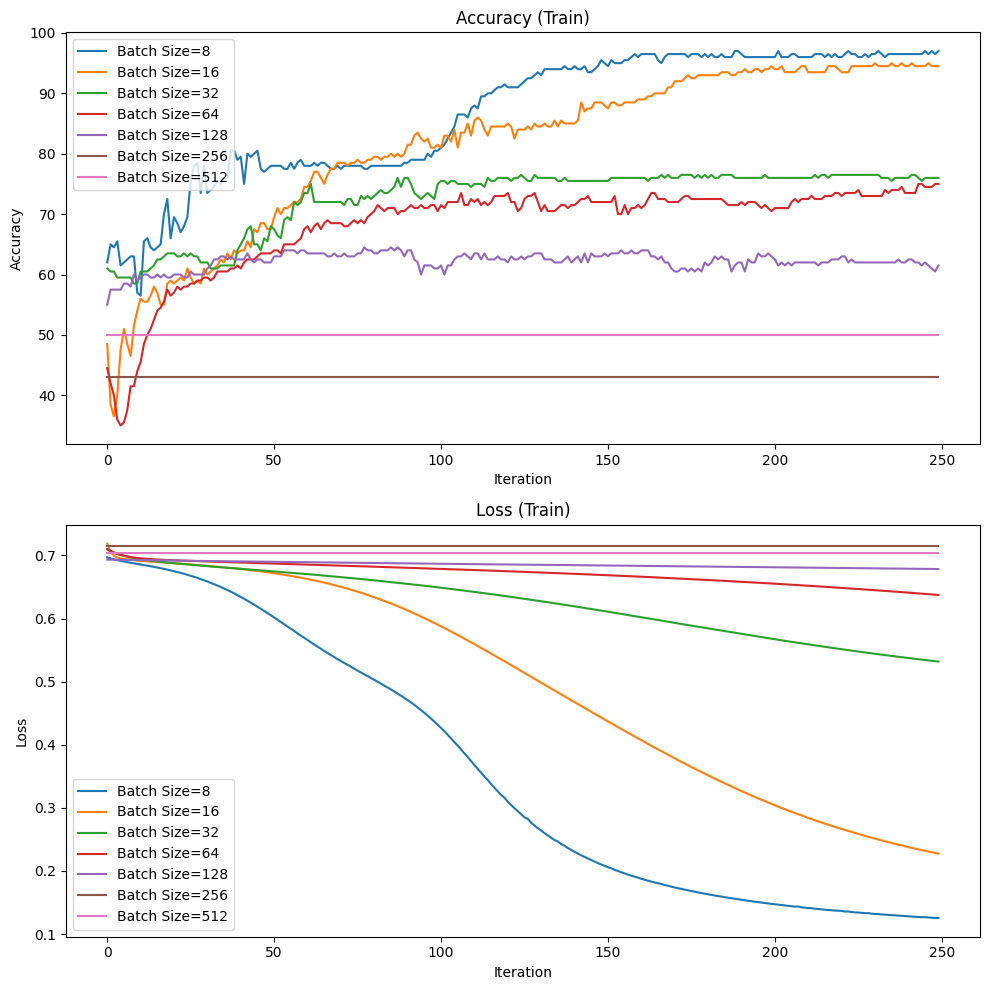

In [46]:
def train_with_batch_size(data, batch_size, num_iterations=250):
    N = data.Xtrain.shape[0]
    nx = data.Xtrain.shape[1]
    nh = 10
    ny = data.Ytrain.shape[1]

    model, loss_fn = init_model(nx, nh, ny)

    curves = [[], [], [], []]

    pbar = trange(num_iterations, desc=f"Batch Size: {batch_size}")

    for iteration in pbar:
        perm = torch.randperm(N)
        Xtrain = data.Xtrain[perm]
        Ytrain = data.Ytrain[perm]

        for j in range(N // batch_size):
            indsBatch = range(j * batch_size, (j + 1) * batch_size)
            X = Xtrain[indsBatch]
            Y = Ytrain[indsBatch]

            # Forward pass
            Yhat = model(X)

            # Calculate loss and accuracy
            L, acc = loss_accuracy(loss_fn, Yhat, Y)
            L.backward()

            # Update parameters using SGD
            model = sgd(model, eta=eta)

        Yhat_train = model(data.Xtrain)
        Yhat_test = model(data.Xtest)
        Ltrain, acctrain = loss_accuracy(loss_fn, Yhat_train, data.Ytrain)
        Ltest, acctest = loss_accuracy(loss_fn, Yhat_test, data.Ytest)

        curves[0].append(acctrain)
        curves[1].append(acctest)
        curves[2].append(Ltrain.detach().numpy())
        curves[3].append(Ltest.detach().numpy())

        title = f"Batch Size: {batch_size}, Iter {iteration + 1}: Acc train {acctrain:.1f}% ({Ltrain:.2f}), acc test {acctest:.1f}% ({Ltest:.2f})"
        pbar.set_description(title)

    return curves

# Initialize data and batch sizes
data = CirclesData()
batch_sizes = [8, 16, 32, 64, 128, 256, 512]
curves = {}

# Train with different batch sizes
for batch_size in batch_sizes:
    curves[batch_size] = train_with_batch_size(data, batch_size=batch_size)

# Plot the results for each batch size
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
for batch_size, curve in curves.items():
    axes[0].plot(curve[0], label=f"Batch Size={batch_size}")
    axes[1].plot(curve[2], label=f"Batch Size={batch_size}")

axes[0].set_title("Accuracy (Train)")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

axes[1].set_title("Loss (Train)")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Loss")
axes[1].legend()

plt.tight_layout()
plt.savefig("torchnn_batch_size.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Part 4 : Simplification of the SGD with `torch.optim`

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim

def init_model(nx, nh, ny, eta):
    model = nn.Sequential(
        nn.Linear(nx, nh),
        nn.Tanh(),
        nn.Linear(nh, ny),
        nn.Softmax(dim=1)
    )
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=eta)
    return model, loss_fn, optimizer


The `sgd` function is replaced by calling the `optim.zero_grad()` before the backward and `optim.step()` after.

## Algorithme global d'apprentissage (avec autograd, les couches `torch.nn` et `torch.optim`)

In [ ]:
# Initialize data and hyperparameters
data = CirclesData()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03

model, loss_fn, optimizer = init_model(nx, nh, ny, eta)

curves = [[], [], [], []]

pbar = trange(500)

# Training loop
for iteration in pbar:
    # Permute the data
    perm = torch.randperm(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    # Batches
    for j in range(N // Nbatch):
        indsBatch = range(j * Nbatch, (j + 1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        # Optimization
        optimizer.zero_grad()
        Yhat = model(X)
        L, acc = loss_accuracy(loss_fn, Yhat, Y)
        L.backward()
        optimizer.step()

    # Evaluate and record performance
    Yhat_train = model(data.Xtrain)
    Yhat_test = model(data.Xtest)
    Ltrain, acctrain = loss_accuracy(loss_fn, Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(loss_fn, Yhat_test, data.Ytest)
    Ygrid = model(data.Xgrid)

    title = "Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})".format(
        iteration, acctrain, Ltrain, acctest, Ltest
    )
    pbar.set_description(title)
    data.plot_data_with_grid(nn.Softmax(dim=1)(Ygrid.detach()), title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain.detach())
    curves[3].append(Ltest.detach())

# Plot the learning and loss curves
fig = plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.title("Learning curves")
plt.legend()
plt.subplot(122)
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.title("Loss curves")
plt.legend()
plt.tight_layout()
plt.savefig("torchoptim_acc_loss.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Influence of Learning rate

LR: 0.001, Iter 500: Acc train 54.5% (0.69), acc test 55.5% (0.69): 100%|██████████| 500/500 [00:10<00:00, 46.30it/s]
LR: 0.01, Iter 500: Acc train 79.5% (0.57), acc test 81.5% (0.57): 100%|██████████| 500/500 [00:10<00:00, 47.82it/s]
LR: 0.05, Iter 500: Acc train 98.0% (0.37), acc test 95.5% (0.38): 100%|██████████| 500/500 [00:10<00:00, 47.82it/s]
LR: 0.1, Iter 500: Acc train 95.5% (0.37), acc test 95.0% (0.38): 100%|██████████| 500/500 [00:10<00:00, 49.95it/s]
LR: 0.5, Iter 500: Acc train 98.0% (0.34), acc test 93.5% (0.37): 100%|██████████| 500/500 [00:10<00:00, 49.99it/s]


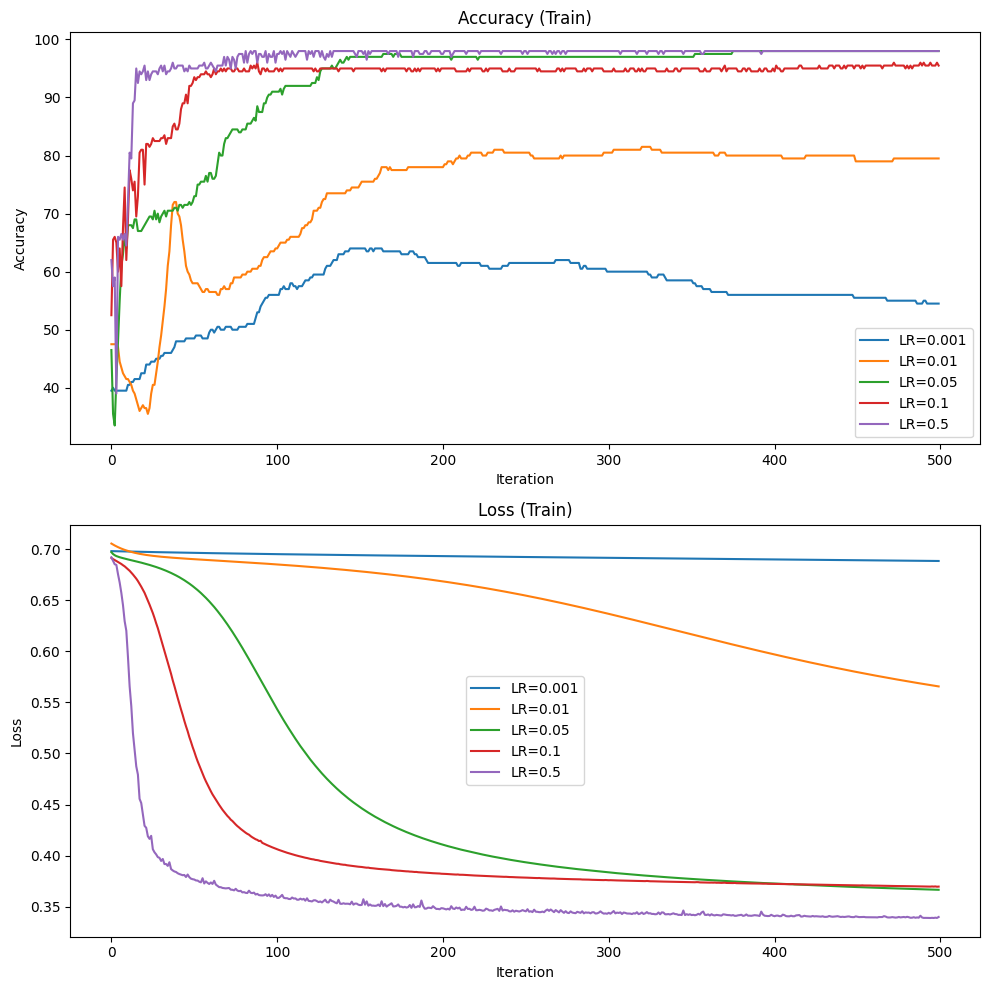

In [49]:
def train_with_learning_rates():
    import matplotlib.pyplot as plt
    from tqdm import trange

    data = CirclesData()
    N = data.Xtrain.shape[0]
    Nbatch = 10
    nx = data.Xtrain.shape[1]
    nh = 10
    ny = data.Ytrain.shape[1]
    learning_rates = [0.001, 0.01, 0.05, 0.1, 0.5]  # List of learning rates to test

    curves = {lr: [[], [], [], []] for lr in learning_rates}

    num_iterations = 500

    for lr in learning_rates:
        model, loss, optim = init_model(nx, nh, ny, lr)
        pbar = trange(num_iterations, desc=f"LR: {lr}")

        for iteration in pbar:
            perm = np.random.permutation(N)
            Xtrain = data.Xtrain[perm, :]
            Ytrain = data.Ytrain[perm, :]

            for j in range(N // Nbatch):
                indsBatch = range(j * Nbatch, (j + 1) * Nbatch)
                X = Xtrain[indsBatch, :]
                Y = Ytrain[indsBatch, :]

                optim.zero_grad()

                Yhat = model(X)
                L, acc = loss_accuracy(loss, Yhat, Y)
                L.backward()

                optim.step()

            Yhat_train = model(data.Xtrain)
            Yhat_test = model(data.Xtest)
            Ltrain, acctrain = loss_accuracy(loss, Yhat_train, data.Ytrain)
            Ltest, acctest = loss_accuracy(loss, Yhat_test, data.Ytest)

            curves[lr][0].append(acctrain)
            curves[lr][1].append(acctest)
            curves[lr][2].append(Ltrain.detach().numpy())
            curves[lr][3].append(Ltest.detach().numpy())

            title = f"LR: {lr}, Iter {iteration + 1}: Acc train {acctrain:.1f}% ({Ltrain:.2f}), acc test {acctest:.1f}% ({Ltest:.2f})"
            pbar.set_description(title)

    # Plot the results for each learning rate
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
    for lr, curve in curves.items():
        axes[0].plot(curve[0], label=f"LR={lr}")
        axes[1].plot(curve[2], label=f"LR={lr}")

    axes[0].set_title("Accuracy (Train)")
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend()

    axes[1].set_title("Loss (Train)")
    axes[1].set_xlabel("Iteration")
    axes[1].set_ylabel("Loss")
    axes[1].legend()

    plt.tight_layout()
    plt.savefig("torchoptim_lr.pdf", format="pdf", bbox_inches="tight")
    plt.show()

# Call the function to execute the training
train_with_learning_rates()


# Influence of batch size

Batch Size: 8, Iter 500: Acc train 95.5% (0.38), acc test 95.5% (0.39): 100%|██████████| 500/500 [00:12<00:00, 40.50it/s]
Batch Size: 16, Iter 500: Acc train 96.5% (0.42), acc test 94.0% (0.43): 100%|██████████| 500/500 [00:07<00:00, 64.34it/s]
Batch Size: 32, Iter 500: Acc train 87.5% (0.52), acc test 85.0% (0.53): 100%|██████████| 500/500 [00:04<00:00, 113.54it/s]
Batch Size: 64, Iter 500: Acc train 74.5% (0.65), acc test 75.0% (0.65): 100%|██████████| 500/500 [00:03<00:00, 144.80it/s]
Batch Size: 128, Iter 500: Acc train 67.0% (0.68), acc test 65.0% (0.68): 100%|██████████| 500/500 [00:02<00:00, 202.01it/s]
Batch Size: 256, Iter 500: Acc train 53.5% (0.70), acc test 54.0% (0.70): 100%|██████████| 500/500 [00:01<00:00, 315.77it/s]


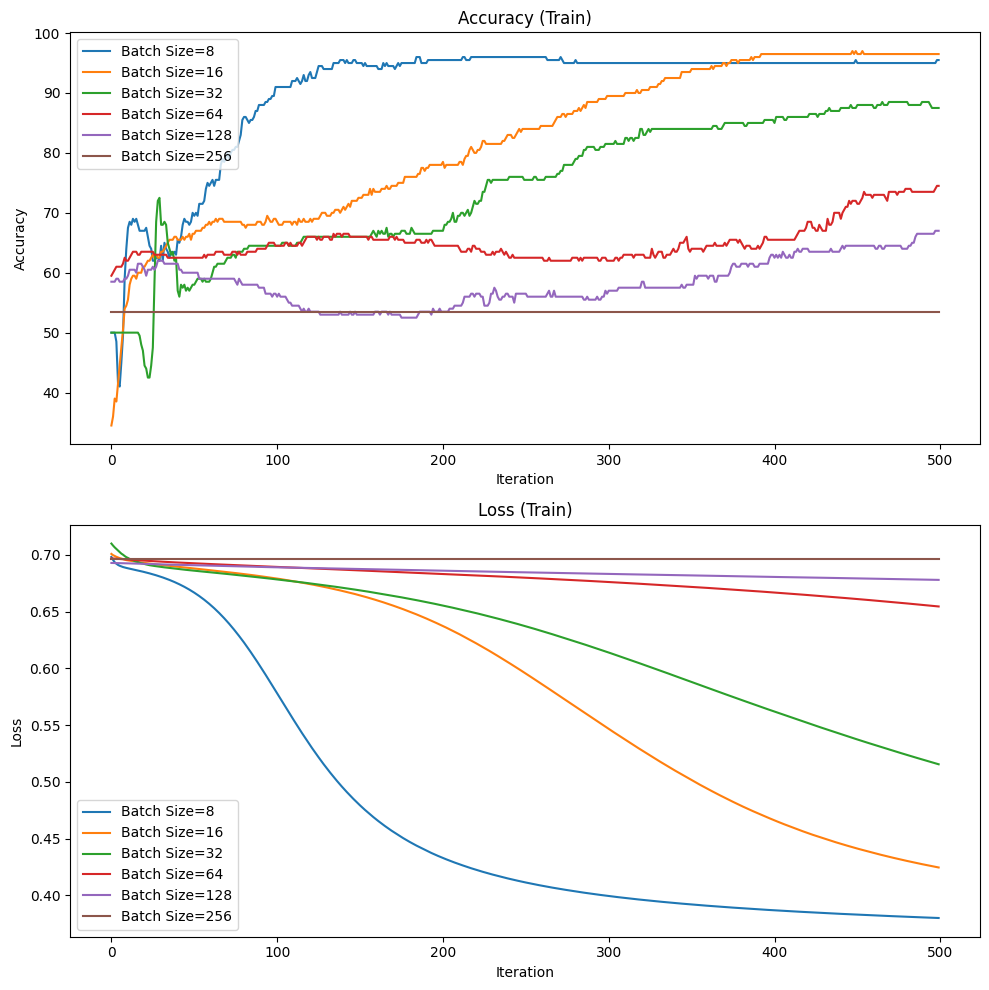

In [50]:
def train_with_batch_sizes():
    import matplotlib.pyplot as plt
    from tqdm import trange

    data = CirclesData()
    N = data.Xtrain.shape[0]
    nx = data.Xtrain.shape[1]
    nh = 10
    ny = data.Ytrain.shape[1]
    batch_sizes = [8, 16, 32, 64, 128, 256]  # List of batch sizes to test

    curves = {batch_size: [[], [], [], []] for batch_size in batch_sizes}

    num_iterations = 500

    for Nbatch in batch_sizes:
        model, loss, optim = init_model(nx, nh, ny, 0.03)
        pbar = trange(num_iterations, desc=f"Batch Size: {Nbatch}")

        for iteration in pbar:
            perm = np.random.permutation(N)
            Xtrain = data.Xtrain[perm, :]
            Ytrain = data.Ytrain[perm, :]

            for j in range(N // Nbatch):
                indsBatch = range(j * Nbatch, (j + 1) * Nbatch)
                X = Xtrain[indsBatch, :]
                Y = Ytrain[indsBatch, :]

                optim.zero_grad()

                Yhat = model(X)
                L, acc = loss_accuracy(loss, Yhat, Y)
                L.backward()

                optim.step()

            Yhat_train = model(data.Xtrain)
            Yhat_test = model(data.Xtest)
            Ltrain, acctrain = loss_accuracy(loss, Yhat_train, data.Ytrain)
            Ltest, acctest = loss_accuracy(loss, Yhat_test, data.Ytest)

            curves[Nbatch][0].append(acctrain)
            curves[Nbatch][1].append(acctest)
            curves[Nbatch][2].append(Ltrain.detach().numpy())
            curves[Nbatch][3].append(Ltest.detach().numpy())

            title = f"Batch Size: {Nbatch}, Iter {iteration + 1}: Acc train {acctrain:.1f}% ({Ltrain:.2f}), acc test {acctest:.1f}% ({Ltest:.2f})"
            pbar.set_description(title)

    # Plot the results for each batch size
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
    for Nbatch, curve in curves.items():
        axes[0].plot(curve[0], label=f"Batch Size={Nbatch}")
        axes[1].plot(curve[2], label=f"Batch Size={Nbatch}")

    axes[0].set_title("Accuracy (Train)")
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend()

    axes[1].set_title("Loss (Train)")
    axes[1].set_xlabel("Iteration")
    axes[1].set_ylabel("Loss")
    axes[1].legend()

    plt.tight_layout()
    plt.savefig("torchoptim_batchsize.pdf", format="pdf", bbox_inches="tight")
    plt.show()

# Call the function to execute the training
train_with_batch_sizes()


# Part 5 : MNIST

Apply the code from previous part code to the MNIST dataset.

In [51]:
# Initialization
data = MNISTData()
N = data.Xtrain.shape[0]
Nbatch = 100
nx = data.Xtrain.shape[1]
nh = 100
ny = data.Ytrain.shape[1]
eta = 0.03

# Initialize the model, loss, and optimizer
model, loss, optim = init_model(nx, nh, ny, eta)

# Initialize lists to store training curves
curves = [[], [], [], []]


  0%|          | 0/100 [00:00<?, ?it/s]

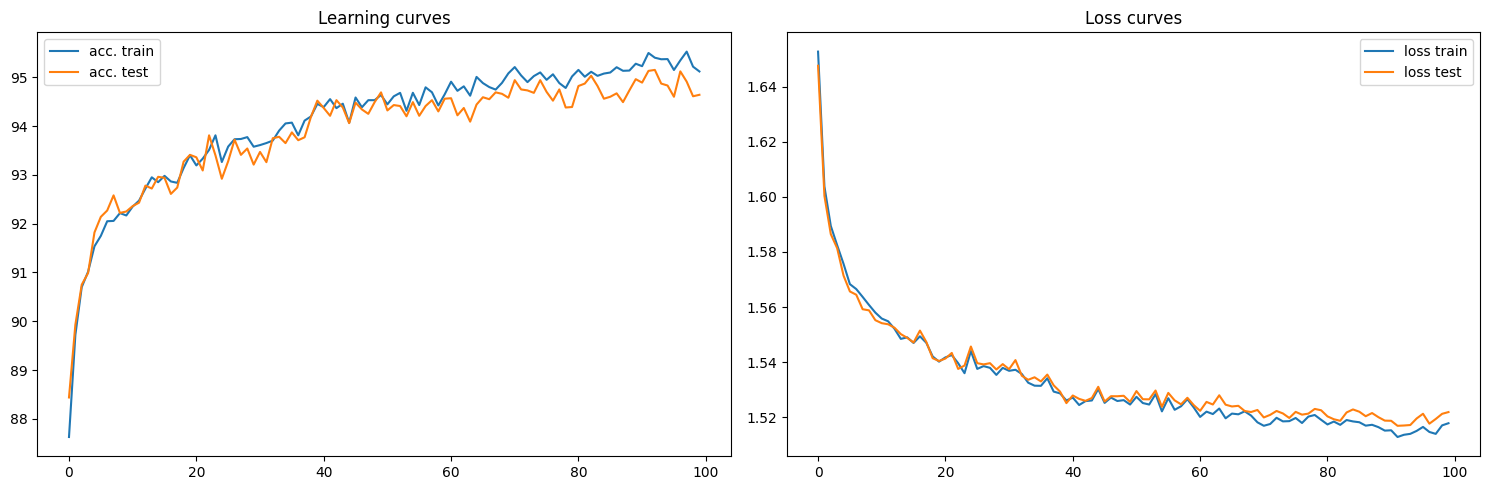

In [52]:
# Training loop
pbar = trange(100)  # Number of epochs

# Initialize lists to store training curves
curves = [[], [], [], []]

# Training epoch
for iteration in pbar:
    # Permute the data
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    # Batch processing
    for j in range(N // Nbatch):
        indsBatch = range(j * Nbatch, (j + 1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        # Zero out gradients
        optim.zero_grad()

        # Forward pass
        Yhat = model(X)

        # Calculate loss and accuracy
        L, acc = loss_accuracy(loss, Yhat, Y)

        # Backward pass and optimization step
        L.backward()
        optim.step()

    # Evaluate on training and test sets
    Yhat_train = model(data.Xtrain)
    Yhat_test = model(data.Xtest)
    Ltrain, acctrain = loss_accuracy(loss, Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(loss, Yhat_test, data.Ytest)

    # Update progress bar description
    title = "Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})".format(
        iteration, acctrain, Ltrain, acctest, Ltest
    )
    pbar.set_description(title)

    # Append results to training curves
    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain.detach())
    curves[3].append(Ltest.detach())

# Plot training curves
fig = plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.title("Learning curves")
plt.legend()
plt.subplot(122)
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.title("Loss curves")
plt.legend()
plt.tight_layout()
plt.savefig("mnist_acc_loss.pdf", format="pdf", bbox_inches="tight")
plt.show()


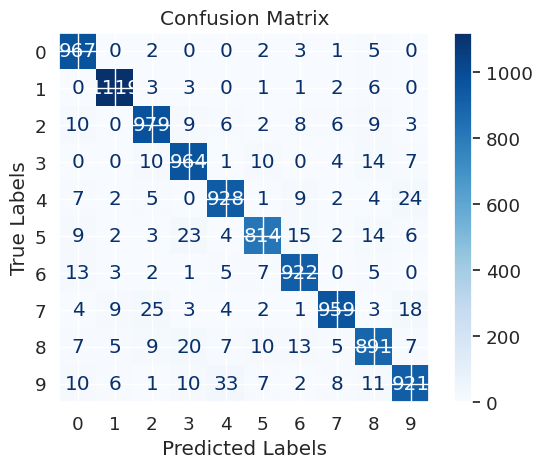

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate the confusion matrix
cm = confusion_matrix(data.Ytest.argmax(dim=1), Yhat_test.detach().argmax(dim=1))

# Create a confusion matrix display
cm_display = ConfusionMatrixDisplay(cm)

# Plot the confusion matrix
cm_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Save the confusion matrix plot to a PDF file
plt.savefig("mnist_cm.pdf", format="pdf", bbox_inches="tight")

# Show the confusion matrix plot
plt.show()


# Part 6: Bonus: SVM


Train a SVM model on the Circles dataset.

Ideas :
- First try a linear SVM (sklearn.svm.LinearSVC dans scikit-learn). Does it work well ? Why ?
- Then try more complex kernels (sklearn.svm.SVC). Which one is the best ? why ?
- Does the parameter C of regularization have an impact? Why ?

In [74]:
# data
data = CirclesData()
Xtrain = data.Xtrain.numpy()
Ytrain = data.Ytrain[:, 0].numpy()

Xgrid = data.Xgrid.numpy()

Xtest = data.Xtest.numpy()
Ytest = data.Ytest[:, 0].numpy()

def plot_svm_predictions(data, predictions):
      plt.figure(2)
      plt.clf()
      plt.imshow(np.reshape(predictions, (40,40)))
      plt.plot(data._Xtrain[data._Ytrain[:,0] == 1,0]*10+20, data._Xtrain[data._Ytrain[:,0] == 1,1]*10+20, 'bo', label="Train")
      plt.plot(data._Xtrain[data._Ytrain[:,1] == 1,0]*10+20, data._Xtrain[data._Ytrain[:,1] == 1,1]*10+20, 'ro')
      plt.plot(data._Xtest[data._Ytest[:,0] == 1,0]*10+20, data._Xtest[data._Ytest[:,0] == 1,1]*10+20, 'b+', label="Test")
      plt.plot(data._Xtest[data._Ytest[:,1] == 1,0]*10+20, data._Xtest[data._Ytest[:,1] == 1,1]*10+20, 'r+')
      plt.xlim(0,39)
      plt.ylim(0,39)
      plt.clim(0.3,0.7)
      plt.draw()
      plt.pause(1e-3)

## Use of a linear SVM Model : LinearSVC


In [75]:
from sklearn.svm import LinearSVC
import time

svm = LinearSVC(random_state=0, tol=1e-5)

start = time.time()
svm.fit(Xtrain, Ytrain)
elapsed_time = time.time() - start

model_name = svm.__class__.__name__

score_train = svm.score(Xtrain, Ytrain)
score_test = svm.score(Xtest, Ytest)
print(f"The accuracy on the train set using a {model_name} is {score_train:.3f} "
      f"with a fitting time of {elapsed_time:.3f} seconds ")
print(f"The accuracy on the test set using a {model_name} is {score_test:.3f} "
      f"with a fitting time of {elapsed_time:.3f} seconds ")

The accuracy on the train set using a LinearSVC is 0.500 with a fitting time of 0.006 seconds 
The accuracy on the test set using a LinearSVC is 0.530 with a fitting time of 0.006 seconds 


Accuracy : 53.00


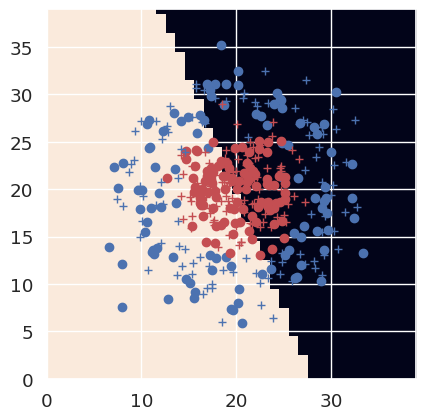

In [77]:
## Print results

Ytest_pred = svm.predict(Xtest)
accuracy = np.sum(Ytest == Ytest_pred) / len(Ytest)
print(f"Accuracy : {100 * accuracy:.2f}")
Ygrid_pred = svm.predict(Xgrid)
plot_svm_predictions(data, Ygrid_pred)

# Observations:

The model perfomrmance on both train and test set are poor, this can be simply explained by the fact that data are not linearly separable and we attempt to classify it using a linear classifier (LinearSVC).

## Use of a more complex kernels : SVC


In [78]:
from sklearn.svm import SVC
import time


svc = SVC(random_state=0, tol=1e-5)

start = time.time()
svc.fit(Xtrain, Ytrain)
elapsed_time = time.time() - start

model_name = svm.__class__.__name__

score_train = svm.score(Xtrain, Ytrain)
score_test = svm.score(Xtest, Ytest)
print(f"The accuracy on the train set using a {model_name} is {score_train:.3f} "
      f"with a fitting time of {elapsed_time:.3f} seconds ")
print(f"The accuracy on the test set using a {model_name} is {score_test:.3f} "
      f"with a fitting time of {elapsed_time:.3f} seconds ")

The accuracy on the train set using a LinearSVC is 0.500 with a fitting time of 0.010 seconds 
The accuracy on the test set using a LinearSVC is 0.530 with a fitting time of 0.010 seconds 


Accuracy : 94.00


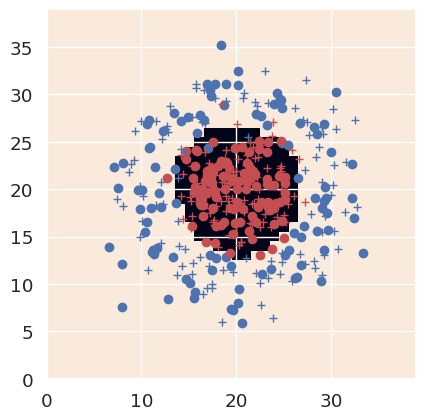

In [79]:
## Print results
Ytest_pred = svc.predict(Xtest)
accuracy = np.sum(Ytest == Ytest_pred) / len(Ytest)
print(f"Accuracy : {100 * accuracy:.2f}")
Ygrid_pred = svc.predict(Xgrid)
plot_svm_predictions(data, Ygrid_pred)